# Use Geometric Center for Clustering

## Import processed data

In [6]:
import numpy as np

rsd_ctr = np.genfromtxt('rsd_array_GeometricCentroids.csv', delimiter=',')
assert len(rsd_ctr) == 2454

## Run DBSCAN

In [7]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(rsd_ctr)

# Compute CBSCAN
eps_value = 0.1
db = DBSCAN(eps=eps_value, min_samples=10).fit(X)
# eps: max distance between two neighnoring samples
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.


In [8]:
# Mark core samples

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True 
# use a new list to mark every core point as True
# core_sample_indices_ : array, shape = [n_core_samples]; indices of core samples

# import collections
# collections.Counter(core_samples_mask)
# collections.Counter(db.labels_)

In [9]:
# Show some data details

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(rsd_ctr, labels))

Estimated number of clusters: 25
Estimated number of noise points: 819
Silhouette Coefficient: -0.182


## Draw the Graph

Text(0.5, 1.0, 'DBSCAN - num of clusters: 25 \n points with cover are core point, while others are phriphery points')

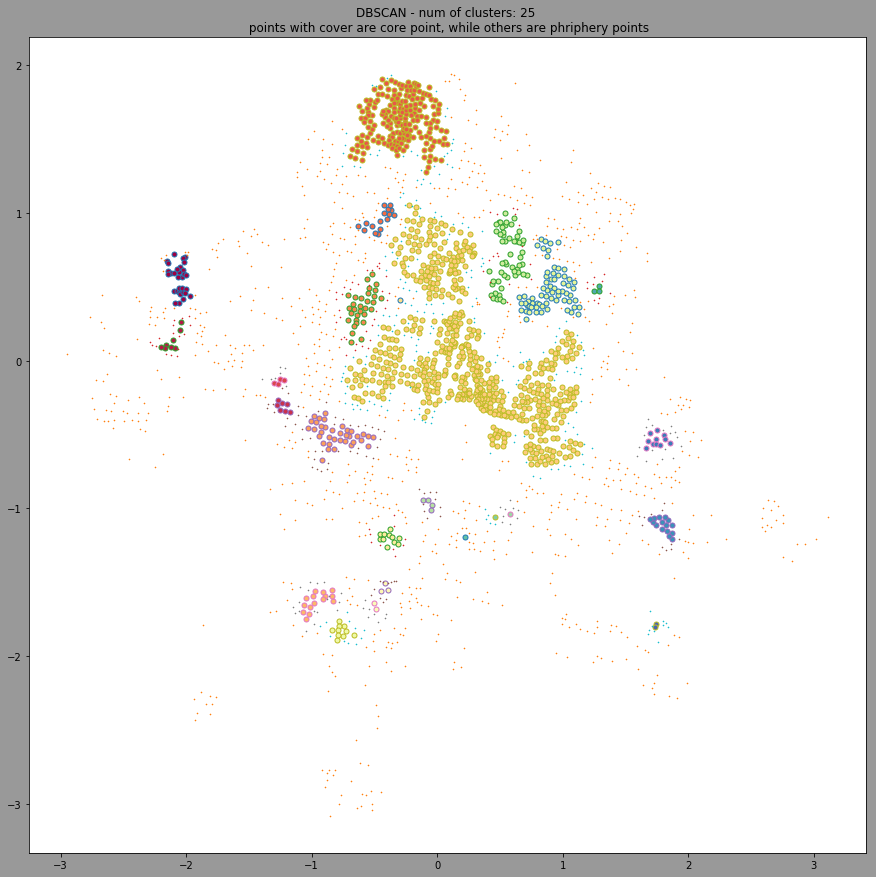

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,15), facecolor='.6')
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=None, markersize=5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),
             markeredgecolor=None, markersize=1)


plt.title('DBSCAN - num of clusters: %d \n points with cover are core point, while others are phriphery points' % n_clusters_)
# plt.show()

# Analyzing Clusters - Area

For each cluster, produce its total area, built area, and number of structures, and other relevant info

In [12]:
import numpy as np
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape, LineString
import pandas as pd

labels = db.labels_
num_clusters = n_clusters_

In [13]:
rawMap = fiona.open('Data/Residences.shp')

# assort all the geoPy objects in the geoMap list
geoMap = []
for i in range(len(rawMap)):
    if rawMap[i]['geometry'] == None:
        print(i, 'is None')
    else:
        try:
            geoMap.append(Polygon(shape(rawMap[i]['geometry'])))
        except:
            print(i, 'has error')
assert len(geoMap) == len(rsd_ctr)

2447 has error
2448 is None


In [14]:
# assort all the geoPy objects in the geoMap list
geoMap = []
for i in range(len(rawMap)):
    if rawMap[i]['geometry'] == None:
        print(i, 'is None')
    else:
        try:
            geoMap.append(Polygon(shape(rawMap[i]['geometry'])))
        except:
            print(i, 'has error')
assert len(geoMap) == len(rsd_ctr)

2447 has error
2448 is None


In [15]:
# dfArea is a DataFrame that contain the area of each building center point
dfArea = pd.DataFrame( columns = ['area', 'cluster'])
dfArea.area = [m.area for m in geoMap]
dfArea.cluster = labels

In [16]:
# Setup the result DataFrame
Results = pd.DataFrame(columns = 
['number_of_buildings', 'total_area', 'built_area', 'building_density',
 'max_area', 'min_area', 'mean_area', 'Gini_coefficient' ])

#### Calculate number_of_buildings, built_area, max_area, min_area, mean_area

In [25]:
# add data for cluster_number, number_of_buildings, total_area
Results.number_of_buildings = [len(dfArea[dfArea.cluster == i]) for i in range(num_clusters) ]
Results.built_area = [ sum(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.max_area = [ max(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.min_area = [ min(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]


### Gini Coefficient

In [18]:
# Calculate Gini Coefficient for each cluster
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

Results.Gini_coefficient = [ gini(np.asarray(dfArea[dfArea.cluster == i].area)) for i in range(num_clusters) ]


#### Calculate total area of a cluster

In [19]:
# Calculate total area of each cluster region
# use the area convexHull of all center in the cluster
# http://scipy.github.io/devdocs/generated/scipy.spatial.ConvexHull.html
grouped_ctr = [[] for i in range(num_clusters)]
for i in range(len(rsd_ctr)):
    grouped_ctr[labels[i]].append(rsd_ctr[i])

In [20]:
# each item in convexhulls is a ConvexHull object consisted of the cluster
from scipy.spatial import ConvexHull

convexhulls = []
for i in range(num_clusters):
    convexhulls.append(ConvexHull(grouped_ctr[i]) )

Results.total_area = [ i.area for i in  convexhulls]

#### Calculate built_area and building_density

In [21]:
Results.built_area = [
    sum(dfArea[dfArea.cluster == i].area) for i in range(num_clusters)
]

In [22]:
Results.building_density = [
    Results.built_area[i]/Results.total_area[i] for i in range(num_clusters)
]

#### Calculate a total row

This table is the result of analyzing all these clusters. The index columns on the left indicates info for each cluster. Row no. 13 is done on the entire map <br/>
Illustration:  <br/>
**built_area**: total area of building in the cluster <br/>
**total_area**: total area of the cluster, measured by the area of the smallest convex hull that contain all center points of buildings in the cluster <br/>
**building_density**: built_area/total_area. Possibly due to different algorithms of the packages I used, the unit is wrong. However, I manually checked that the density here is a correct characterization the building density on the graph. So, qualitative comparisons can be made. <br/>
**max/min/mean_area**: max/min/mean area of all the buildings in each cluster <br/>
**Gini_coefficient**: the gini coefficient for all the areas of buildings in the cluster  <br/>
**Gini_Diff**: Gini of the cluster - Gini of the whole region

In [48]:
Results.append({
    'number_of_buildings': len(rsd_ctr), 'total_area': sum(Results.total_area), 
    'built_area': sum(dfArea.area), 'max_area': max(dfArea.area), 'min_area': min(dfArea.area),
    'mean_area': sum(dfArea.area)/sum(Results.total_area), 'Gini_coefficient': gini(np.asarray(dfArea.area)),
    'building_density': sum(dfArea.area)/sum(Results.total_area)
}, ignore_index=True)

,number_of_buildings,total_area,built_area,building_density,max_area,min_area,mean_area,Gini_coefficient,Gini_diff
0,44.0,1571.467687,3.048285e+04,19.397692,3102.324753,153.730146,35.715175,0.378189,-0.042280
1,24.0,1164.409144,3.716276e+04,31.915550,3165.013891,183.762128,48.517048,0.259047,-0.161422
2,18.0,988.294800,5.077519e+04,51.376564,7560.498991,577.538118,54.905267,0.401669,-0.018800
3,11.0,666.222198,2.461446e+04,36.946329,7555.458659,700.606240,60.565654,0.371939,-0.048530
4,235.0,3401.002568,3.525577e+05,103.662875,4513.110365,168.011089,14.472351,0.355455,-0.065013
5,35.0,1368.972766,7.394296e+04,54.013464,5574.191850,304.520098,39.113508,0.342794,-0.077675
6,65.0,2180.284051,1.746795e+05,80.117758,7275.090155,94.399830,33.542832,0.308497,-0.111972
7,67.0,2263.071649,2.268033e+05,100.219220,10834.965106,364.024026,33.777189,0.271387,-0.149082
8,33.0,1415.521647,4.353365e+04,30.754493,3496.870793,150.072405,42.894595,0.413160,-0.007309
9,738.0,7976.905361,1.346984e+06,168.860509,34636.313970,55.488462,10.808815,0.437551,0.017082


In [47]:
sum(Results.number_of_buildings)

1635

### Histogram for the allocation of areas in a cluster

Text(0.5, 1.0, 'asdf')

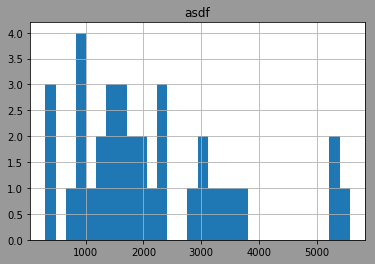

In [28]:

i = 5 # change i to desired cluster number to view 
plt.figure(facecolor = '.6')
hist_fig = dfArea[dfArea.cluster == i].area.hist(bins = 30).get_figure()
plt.title('asdf')
# dfArea.area.dropna().plot(kind='kde',xlim=(0,5*10e3), style='r--')